In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import bisect
from loguru import logger
import matplotlib.pyplot as plt
from converter import UTMtoLL, LLtoUTM
import os

In [2]:
def extract_lat_lon_from_file(file_path):
    lat, lon = None, None
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('latitude:'):
                lat = float(line.strip().split(':')[1])
            elif line.strip().startswith('longitude:'):
                lon = float(line.strip().split(':')[1])
    return [lat, lon] if lat is not None and lon is not None else None

def read_all_casualty_coords(directory):
    coords = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            lat_lon = extract_lat_lon_from_file(file_path)
            if lat_lon:
                coords.append(lat_lon)
    return coords

# Example usage:
directory_path = '/mnt/UNENCRYPTED/ruichend/seq/dry_run_1/GT'
casualty_gps = np.array(read_all_casualty_coords(directory_path))
casualty_coords = np.array([LLtoUTM(23, lat, lon) for lat, lon in casualty_gps])[:, 1:3].astype(np.float32)  # Extracting easting and northing

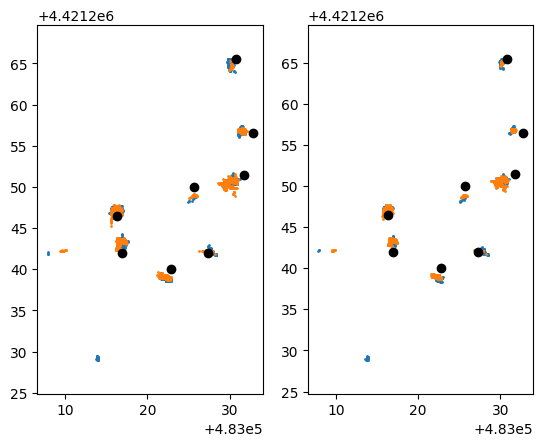

In [6]:
plt.subplot(1, 2, 1)
target = np.load('logs/with_ts4.npy')
plt.axis('equal')
target1 = target[:len(target)//2, :2]  # Use only the first two columns for plotting
plt.scatter(target1[:, 1], target1[:, 0],  s=1)
target2 = target[len(target)//2:, :2]  # Use only the first two columns for plotting
plt.scatter(target2[:, 1], target2[:, 0],  s=1)
plt.scatter(casualty_coords[:, 0], casualty_coords[:, 1], label='Ground Truth', color='black')

plt.subplot(1, 2, 2)
target = np.load('logs/with_ts5.npy')
plt.axis('equal')
target1 = target[:len(target)//2, :2]  # Use only the first two columns for plotting
plt.scatter(target1[:, 1], target1[:, 0],  s=1)
target2 = target[len(target)//2:, :2]  # Use only the first two columns for plotting
plt.scatter(target2[:, 1], target2[:, 0],  s=1)
plt.scatter(casualty_coords[:, 0], casualty_coords[:, 1], label='Ground Truth', color='black')

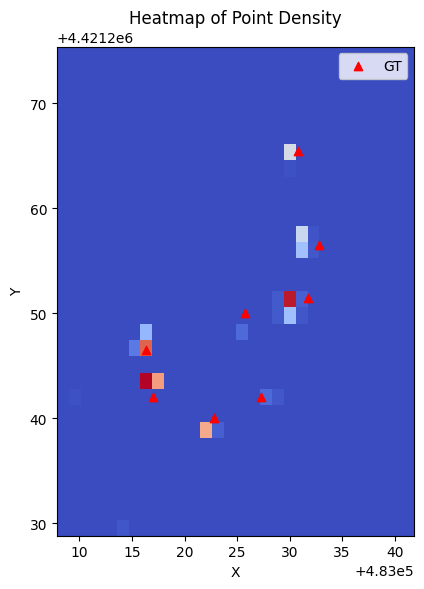

In [7]:


xmin = np.min(target[:, 1])
xmax = np.max(target[:, 1])
ymin = np.min(target[:, 0])
ymax = np.max(target[:, 0])
range = [[xmin, xmax+10], [ymin, ymax+10]]
heatmap, xedges, yedges = np.histogram2d(target[:, 1], target[:, 0], bins=30, range = range)
extent = [xmin, xmax+10, ymin, ymax+10]

plt.figure(figsize=(6, 6))
# plt.axis('equal')
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
# plt.imshow(np.ma.masked_where(heatmap.T == 0, heatmap.T), cmap=cmap)

plt.imshow(heatmap.T, extent=extent, origin='lower', interpolation='nearest', cmap="coolwarm")
# plt.colorbar(label='Density')
plt.title('Heatmap of Point Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(casualty_coords[:, 0], casualty_coords[:, 1], marker='^', label='GT', color='r')
plt.legend()
plt.tight_layout()